In [7]:
from tfim_sk_infd.services import jij_service
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import numpy
import sys

numpy.set_printoptions(threshold=sys.maxsize)

T = 4

Jij_instance = jij_service.get_toy_Jij(T)
SG = SKSpinGlass(Jij_instance)

print(SG.JZZ.get_shape())

print(SG.JZZ.diagonal() )

100% |########################################################################|


Building JZZ...
Done.
Building Mx...
Done.
(16, 16)
[-2.  2.  2.  2.  0.  0.  0. -4. -4.  0.  0.  0.  2.  2.  2. -2.]


In [4]:
import numpy as np

# Original NumPy array
original_array = np.array([[1, 2, 3], [4, 5, 6]])

# Convert the NumPy array to a string
array_string = np.array2string(original_array)

In [5]:
print(array_string)

[[1 2 3]
 [4 5 6]]


In [9]:
import json
original_array = np.array([[1, 2, 3], [4, 5, 6]])

arr_str = json.dumps(original_array.tolist())
np.array(json.loads(arr_str))

array([[1, 2, 3],
       [4, 5, 6]])

In [10]:
N=8
(N*(N-1)) / 2

28.0

In [47]:
from tfim_sk_infd.services import jij_service, ground_state_service, qutip_service
import numpy as np

# Get an instance and find ground state
seed = 0
N = 8
Jij = jij_service.Jij_instance(N, seed)
JZZ = jij_service.JZZ_SK(Jij)
gs_list = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]

# Pull out half of the ground states and determine maximum hd
reduced_gs, max_h_d = ground_state_service.maximal_half_clique(gs_list, N)

print(reduced_gs)

gs_size = len(reduced_gs)

# Find quantum annealing final state
Hp = qutip_service.spin_glass_hamiltonian(Jij, N)
Ht = qutip_service.transverse_field_hamiltonian(N)

h = 1e-2
h_t = (-Hp*(1-h)) - (h * Ht)

eigenvalues, eigenstates = h_t.eigenstates(eigvals = 1)

# print(eigenstates[0])

annealing_gs_probs = qutip_service.quantum_anneal(Hp, Ht, N, 1000, 100)

[9, 30]


In [48]:
eigenstates[0].full().flatten()[gs_list]

array([0.49998355+0.j, 0.499984  +0.j, 0.49998385+0.j, 0.49998421+0.j])

In [34]:
np.array(annealing_gs_probs)[gs_list]

array([0.24999996, 0.24999996, 0.24999996, 0.24999996])

In [51]:
for h in (1, 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5 ):
    h_t = (-Hp*(1-h)) - (h * Ht)

    # Calculate condition number
    cond_number = np.linalg.cond(h_t.full())
    print("Condition number:", cond_number)

print(np.linalg.cond(Hp.full()))

Condition number: 8.621715046583702e+17
Condition number: inf
Condition number: 1.8073537748923588e+16
Condition number: 1.1143847909944384e+17
Condition number: 6.501768394827755e+16
Condition number: 1.2890019807250006e+17
Condition number: 1.2631674856366051e+17
inf


In [60]:
h_test = Hp.full()[1:6,1:6]
print(h_test)
print(np.linalg.cond(h_test))

[[ 6.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -6.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  4.+0.j]]
3.0


In [20]:
from tfim_sk_infd.services import ground_state_service
import numpy as np

N = 8
gs = [9,30]

overlap_dist = ground_state_service.overlap_distribution_fair(gs, N)
overlap_dist = overlap_dist.tolist()
od_mean = np.mean(overlap_dist)
manual_mean = sum([ ( ((2*i)/N) - 1) * overlap_dist[i] for i in range(N+1)])
manual_mean_bucket = sum([ i * overlap_dist[i] for i in range(N+1)])
od_variance = np.var(overlap_dist)
manual_variance = sum([ (( (((2*i)/N) - 1) **2) * overlap_dist[i]) - (manual_mean**2) for i in range(N+1)])
manual_variance_bucket = sum([ ((i**2) * overlap_dist[i]) - (manual_mean_bucket**2) for i in range(N+1)])

hd = ground_state_service.base_N_hamming_distance(9,30,8)

In [21]:

bucket_vals = [ ( ((2*i)/N) - 1)  for i in range(N+1)]

print(overlap_dist)
print(manual_mean)
print(manual_mean_bucket)
print(bucket_vals[int(manual_mean_bucket)])
print(od_mean)
print(od_variance)
print(manual_variance)
print(manual_variance_bucket)
print(hd)

[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5]
0.5
6.0
0.5
0.1111111111111111
0.043209876543209874
-1.75
-284.0
4


In [22]:
N = 12
[((2*i)/N) - 1 for i in range(N+1)]
np.var(np.array([0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5]))

0.043209876543209874

In [14]:
import data_service
from database.models import InstancesN8
from tfim_sk_infd.services import qutip_service
from tfim_sk_infd.models.Jij import Jij
import numpy as np

N = 8
h = 1e-2

with data_service.get_session() as session:

    instance = session.query(InstancesN8).where(InstancesN8.seed == 1).all()[0]
    Jij_obj = Jij(np.array(instance.Jij_matrix))

    Ht = qutip_service.transverse_field_hamiltonian(N)
    Hp = qutip_service.spin_glass_hamiltonian(Jij_obj, N)

    h_t = -Hp - h * Ht

    eigenvalues, eigenstates = h_t.eigenstates(eigvals=1)

    gs_probs = [
        round(2 * float(pa.real**2 + pa.imag**2),5)
        for pa in eigenstates[0].full().flatten()[instance.reduced_gs]
    ]

    if abs(sum(gs_probs) - 1) > 1e-2:
        print(
            f"seed {instance.seed} diagonalization fail. gs prob array sum {sum(gs_probs)}\n{gs_probs}"
        )

In [15]:
gs_probs

[0.49997, 0.49997]

In [3]:
from tqdm import tqdm
import time

# Example loop
for i in tqdm(range(100)):
    # Simulate some work with a sleep
    time.sleep(0.1)

100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


In [1]:
"""
python3 -m scripts.add_instances           
python3 -m scripts.update_degeneracy_col
python3 -m scripts.update_reduced_gs_hd
python3 -m scripts.update_overlap_dist 
python3 -m scripts.update_post_anneal_gs_probs
python3 -m scripts.update_post_anneal_cols    
python3 -m scripts.update_post_anneal_gs_hd
"""

'\npython3 -m scripts.add_instances           \npython3 -m scripts.update_degeneracy_col\npython3 -m scripts.update_reduced_gs_hd\npython3 -m scripts.update_overlap_dist \npython3 -m scripts.update_post_anneal_gs_probs\npython3 -m scripts.update_post_anneal_cols    \npython3 -m scripts.update_post_anneal_gs_hd\n'

In [28]:
import numpy as np
from scipy import linalg

from database.models import InstancesN12
from tfim_sk_infd.services import qutip_service
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service

N = 12
h = 1e-1


with data_service.get_session() as session:

    instances = (
        session.query(InstancesN12)
        .where(InstancesN12.degeneracy > 2)
        .all()
    )

    Ht = qutip_service.transverse_field_hamiltonian(N)
    for instance in instances[:2]:


        Jij_obj = Jij(np.array(instance.Jij_matrix))

        # QuTiP
        Hp = qutip_service.spin_glass_hamiltonian(Jij_obj, N)
        h_t = -Hp - h * Ht
        eigenvalues, eigenstates = h_t.eigenstates(eigvals=1)
        gs_probs_q = [
            round(2 * float(pa.real**2 + pa.imag**2), 5)
            for pa in eigenstates[0].full().flatten()[instance.reduced_gs]
        ]
        gs_probs_q_full = [
            round(float(pa.real**2 + pa.imag**2), 5)
            for pa in eigenstates[0].full().flatten()[instance.ground_states]
        ]

        

        # tfim

        SG = SKSpinGlass(Jij_obj)

        # Define Hamiltonian H at h
        H = SG.hamiltonian_at_h(h)

        # Diagonalize H and get ground state vector psi0
        E, v = linalg.eigh(H.todense())
        sort_order = np.argsort(E)
        v = v[:, sort_order]
        psi0 = v[:, 0]

        # retrieve and format probabilities of classical ground states in psi0
        gs_probs_tfim = np.array([2* round(psi0[g] ** 2 ,5)for g in instance.reduced_gs])
        gs_probs_tfim_full = np.array([round(psi0[g] ** 2,5) for g in instance.ground_states])


        # print gs probs

        print("-------------------")
        print(gs_probs_q)
        print(gs_probs_q_full)
        print(gs_probs_tfim)
        print(gs_probs_tfim_full)
        print("-------------------")



    session.commit()

    session.close()


Building JZZ...


100% |########################################################################|


Done.
Building Mx...


100% |########################################################################|


Done.
-------------------
[6e-05, 0.98599]
[3e-05, 0.49299, 0.49822, 3e-05]
[6.0000e-05 9.9432e-01]
[3.0000e-05 4.9716e-01 4.9406e-01 3.0000e-05]
-------------------


Building JZZ...


100% |########################################################################|


Done.
Building Mx...


100% |########################################################################|


Done.
-------------------
[0.21411, 0.21977, 0.05863, 0.21597, 0.0, 0.21278, 0.05013]
[0.10706, 0.10988, 0.0, 0.02931, 0.10639, 0.10799, 0.02506, 0.02506, 0.10799, 0.10639, 0.02931, 0.0, 0.10988, 0.10706]
[0.21412 0.21976 0.05862 0.21598 0.      0.21278 0.05012]
[0.10706 0.10988 0.      0.02931 0.10639 0.10799 0.02506 0.02506 0.10799
 0.10639 0.02931 0.      0.10988 0.10706]
-------------------


In [10]:
o_list = [1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [16]:
import numpy as np



np.histogram(o_list, bins = 13, range=(-1.0,1.0))

(array([ 0,  0,  0,  0,  0,  0, 16,  0,  3,  0,  2,  0,  7]),
 array([-1.        , -0.84615385, -0.69230769, -0.53846154, -0.38461538,
        -0.23076923, -0.07692308,  0.07692308,  0.23076923,  0.38461538,
         0.53846154,  0.69230769,  0.84615385,  1.        ]))

In [24]:
def base_N_hamming_distance(i: int, j: int, N: int) -> int:
    arr_i = np.array([int(s) for s in bin(i)[2:].zfill(N)])
    arr_j = np.array([int(s) for s in bin(j)[2:].zfill(N)])
    return int(np.sum(arr_i != arr_j))

gs_list = [395, 451, 1219, 2507, 2963, 1483, 2441]
gs_probs = [0.21411, 0.21977, 0.05863, 0.21597, 0.0, 0.21278, 0.05013]
hd_histogram = np.zeros(13)
gs_size = len(gs_list)
for i in range(gs_size):
    for j in range(i, gs_size):
        h_d = base_N_hamming_distance(gs_list[i], gs_list[j], N)
        if i != j:
            hd_histogram[h_d] += 2* gs_probs[i] * gs_probs[j]
        else:
            hd_histogram[h_d]+= gs_probs[i] * gs_probs[j]

In [25]:
hd_histogram

array([0.19201081, 0.        , 0.65191084, 0.        , 0.09379864,
       0.        , 0.00587824, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [26]:
hd_histogram.sum()

0.9435985321

In [2]:
from tfim_sk_infd.services.ground_state_service import overlap_distribution_fair, overlap_distribution_weighted

N = 8
gs_list = [395, 451, 1219, 2507, 2963, 1483, 2441]
gs_probs = [0.21411, 0.21977, 0.05863, 0.21597, 0.0, 0.21278, 0.05013]

print(overlap_distribution_fair(gs_list,N))
print(sum(overlap_distribution_fair(gs_list,N)))
print(overlap_distribution_weighted(gs_list,gs_probs, N))
print(sum(overlap_distribution_weighted(gs_list,gs_probs, N)))


ValueError: operands could not be broadcast together with shapes (9,) (11,) 

In [30]:
from tfim_sk_infd.services import ground_state_service
import numpy as np

N = 8
gs = [9,30]

bins = np.array([((2*i)/N) - 1 for i in range(N+1)])
overlap_dist = ground_state_service.overlap_distribution_fair(gs, N)

mean = np.sum(bins*overlap_dist)
variance = np.sum(overlap_dist * (bins - mean) ** 2)

print(mean)
print(variance)

0.5
0.25


In [31]:
from tfim_sk_infd.services import ground_state_service
N = 12
gs_list = [212, 340, 470]

h_d_dict = {}

for i in range(len(gs_list)):
    for j in range(i+1, len(gs_list)):
        x = gs_list[i]
        y = gs_list[j]
        h_d_dict[f"{x}_{y}"] = ground_state_service.base_N_hamming_distance(x,y,N)

h_d_dict



{'212_340': 2, '212_470': 2, '340_470': 2}

In [68]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.services import qutip_service
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from tqdm import tqdm
from scipy import linalg
from scipy.sparse import linalg as spla

N = 8


Instance = data_service.get_instance_class(N)


with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.degeneracy > 2).limit(10).all()
    )

    for instance in instances:

        Jij_obj = Jij(np.array(instance.Jij_matrix))

        SG = SKSpinGlass(Jij_obj)

        # initial diag
        h = 0.1
        H = SG.hamiltonian_at_h(h)
        E, v = spla.eigsh(H, k=instance.degeneracy + 1, which="SA")

        sort_order = np.argsort(E)
        E = E[sort_order]
        v = v[:, sort_order]
        psi0 = v[:, 0]

        min_e_gap = E[1] - E[0]
        if min_e_gap < 1e-15:
            print(f"Diagonalization fail for seed {instance.seed} with min_e_gap {min_e_gap} at h = {h}")
            continue

        fidelity = 0
        while(fidelity < 0.99):
            print("------")
            print(h)
            print(2*psi0[instance.reduced_gs]**2)
            print(2*sum(psi0[instance.reduced_gs]**2))
            h /= 2
            H = SG.hamiltonian_at_h(h)
            E, v = spla.eigsh(H, k=instance.degeneracy + 1, which="SA", v0 = psi0)

            sort_order = np.argsort(E)
            E = E[sort_order]
            v = v[:, sort_order]

            old_psi0 = psi0
            psi0 = v[:, 0]
            
            min_e_gap = E[1] - E[0]
            if min_e_gap < 1e-15:
                print(f"Diagonalization fail for seed {instance.seed} with min_e_gap {min_e_gap} at h = {h}")
                break


            fidelity = np.abs(np.inner(psi0,old_psi0))
            
            


        print("------")
        print(h)
        print(2*psi0[instance.reduced_gs]**2)
        print(2*sum(psi0[instance.reduced_gs]**2))
        print("+++++++++++++++++++++++++")

    session.commit()

    session.close()


------
0.1
[0.49683465 0.49683465]
0.9936692901055844
------
0.05
[0.49921049 0.49921049]
0.9984209716376728
+++++++++++++++++++++++++
------
0.1
[0.45583859 0.53783059]
0.9936691768708635
------
0.05
[0.45804474 0.54037622]
0.9984209555396175
+++++++++++++++++++++++++
------
0.1
[0.1162232  0.20403991 0.3348821  0.1162232  0.20403991]
0.97540830857282
------
0.05
[0.11783242 0.2079024  0.34209439 0.11783242 0.2079024 ]
0.9935640225519484
+++++++++++++++++++++++++
------
0.1
[0.22032272 0.54336332 0.22032272]
0.9840087712887097
------
0.05
[0.22247256 0.55094625 0.22247256]
0.9958913677160331
+++++++++++++++++++++++++
------
0.1
[0.22032272 0.54336332 0.22032272]
0.9840087716621786
------
0.05
[0.22247256 0.55094625 0.22247256]
0.995891365957721
+++++++++++++++++++++++++
------
0.1
[0.49564181 0.49564181]
0.99128362813417
------
0.05
[0.49891093 0.49891093]
0.9978218538978142
+++++++++++++++++++++++++
------
0.1
[0.49350794 0.49350794]
0.9870158750136575
------
0.05
[0.49834266 0.49834

In [56]:
abs(np.inner(psi0,old_psi0))

0.9970200238510123

In [44]:
a = 1
a /= 2
a

0.5

In [113]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla

N = 12


Instance = data_service.get_instance_class(N)


with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.degeneracy > 2).where(Instance.seed == 26).all()
    )
    hx = []
    min_e_list = []
    fid_list = []
    for instance in instances:

        try:

            Jij_obj = Jij(np.array(instance.Jij_matrix))

            SG = SKSpinGlass(Jij_obj)

            # initial diag
            h = 0.4
            H = SG.hamiltonian_at_h(h)
            E, v = spla.eigsh(H, k=2, which="SA")

            sort_order = np.argsort(E)
            E = E[sort_order]
            v = v[:, sort_order]
            psi0 = v[:, 0]

            min_e_gap = E[1] - E[0]
            fidelity = 0
            if min_e_gap < 1e-12:
                raise Exception(
                    f"Diagonalization fail for seed {instance.seed} with min_e_gap {min_e_gap} at h = {h}"
                )
            
            print(h)
            
            hx.append(h)
            min_e_list.append(min_e_gap)
            fidelity=  0
            fid_list.append(fidelity)
            while fidelity < 0.99999:
                h /= 1.5
                print(h)
                H = SG.hamiltonian_at_h(h)
                # E, v = spla.eigsh(H, k=2, which="SA", v0=psi0)
                E, v = spla.eigsh(H, k=2, which="SA")

                sort_order = np.argsort(E)
                E = E[sort_order]
                v = v[:, sort_order]

                old_psi0 = psi0
                psi0 = v[:, 0]

                fidelity = np.abs(np.vdot(psi0, old_psi0))

                min_e_gap = E[1] - E[0]
                if min_e_gap < 1e-15:
                    raise Exception(
                        f"Diagonalization fail for seed {instance.seed} with min_e_gap {min_e_gap} at h = {h}"
                    )
                
                hx.append(h)
                min_e_list.append(min_e_gap)
                fid_list.append(fidelity)

                

            gs_probs = psi0[instance.ground_states]
            print(gs_probs)
            print(h)
            print(min_e_gap)
            print(fidelity)

        except Exception as e:
            print(
                f"Diagonalization fail for seed {instance.seed}, min_e_gap {min_e_gap}, h {h}, fidelity {fidelity}\norgiginal error:\n{e}"
            )

    session.close()

0.4
0.26666666666666666
0.17777777777777778
0.11851851851851852
0.07901234567901234
0.05267489711934156
0.035116598079561044
0.023411065386374028
0.015607376924249352
0.010404917949499567
0.0069366119663330445
0.004624407977555363
0.003082938651703575
0.00205529243446905
0.0013701949563127
0.0009134633042084667
0.0006089755361389778
0.00040598369075931857
0.0002706557938395457
Diagonalization fail for seed 26, min_e_gap 1.4566126083082054e-13, h 0.0002706557938395457, fidelity 0.8454747277743074
orgiginal error:
ARPACK error -1: No convergence (40961 iterations, 1/2 eigenvectors converged)


In [121]:
# Graph min e gap vs hx
# binary search to find optimal h
classical_gs = [212, 340, 470, 3625, 3755, 3883]
print(old_psi0[classical_gs])
print(np.sum(old_psi0[classical_gs]**2))

[-0.11588126 -0.1176956  -0.14878051  0.65253756  0.51619554  0.50825168]
0.9999992360600478


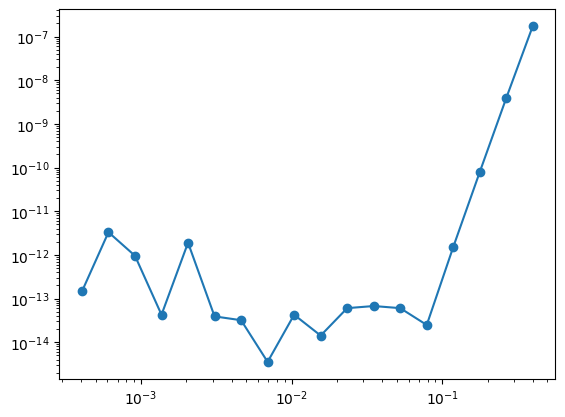

In [125]:
import matplotlib.pyplot as plt

plt.plot(hx, min_e_list, marker='o')
plt.yscale('log')
plt.xscale('log')


plt.show()


In [206]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla
from scipy import linalg

N = 12


Instance = data_service.get_instance_class(N)

seed = 26

with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.degeneracy > 2).where(Instance.seed == seed).all()
    )
    hx = []
    min_e_list = []
    fid_list = []
    classical_gs_prob_list = []
    print(instance.ground_states)
    for instance in instances:

        try:

            Jij_obj = Jij(np.array(instance.Jij_matrix))

            SG = SKSpinGlass(Jij_obj)

            h = 0.4  * 1.5
            psi0 = None

            for i in range(20):
                h /= 1.5
                H = SG.hamiltonian_at_h(h)
                # E, v = spla.eigsh(H, k=len(instance.ground_states) + 1, ncv = 80, which="SA", v0=psi0)
                E,v = linalg.eigh(H.todense())


                sort_order = np.argsort(E)
                E = E[sort_order]
                v = v[:, sort_order]

                old_psi0 = psi0
                psi0 = v[:, 0]


                # Symmetrize
                Spsi = np.flip(psi0)
                phiS = (psi0 + Spsi)
                phiS = phiS / np.sqrt(np.dot(phiS,phiS))
                psi0 = phiS

                fidelity = np.abs(np.vdot(psi0, old_psi0)) if old_psi0 is not None else 0
                min_e_gap = E[1] - E[0]
                
                hx.append(h)
                min_e_list.append(min_e_gap)
                fid_list.append(fidelity)
                classical_gs_prob_list.append(np.sum(psi0[instance.ground_states]**2))

                

        except Exception as e:
            print(
                f"Diagonalization fail for seed {instance.seed}, min_e_gap {min_e_gap}, h {h}, fidelity {fidelity}\norgiginal error:\n{e}"
            )

    session.close()

[212, 340, 470, 3625, 3755, 3883]


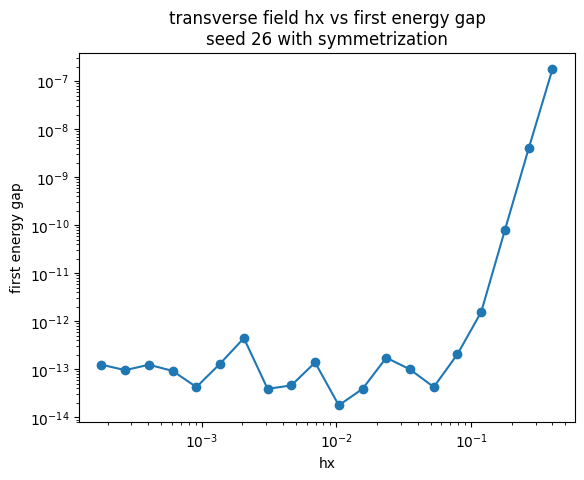

In [200]:
import matplotlib.pyplot as plt

plt.plot(hx, min_e_list, marker='o')
plt.title(f"transverse field hx vs first energy gap\nseed {seed} with symmetrization")
plt.xlabel('hx')
plt.ylabel('first energy gap')
plt.yscale('log')
plt.xscale('log')


plt.show()

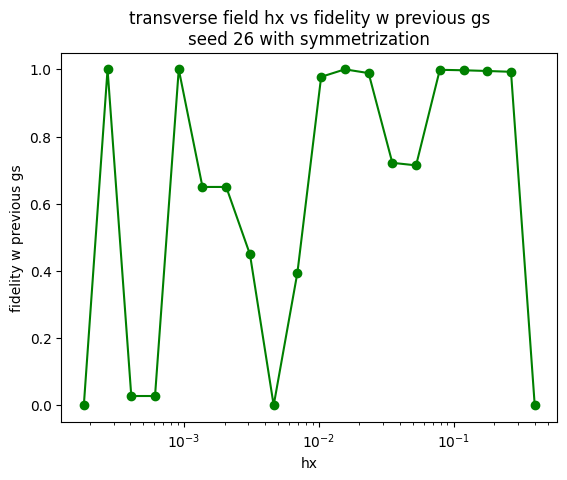

In [201]:
import matplotlib.pyplot as plt

plt.plot(hx, fid_list, marker='o',color='green')
plt.title(f"transverse field hx vs fidelity w previous gs\nseed {seed} with symmetrization")
plt.xlabel('hx')
plt.ylabel('fidelity w previous gs')
plt.xscale('log')


plt.show()

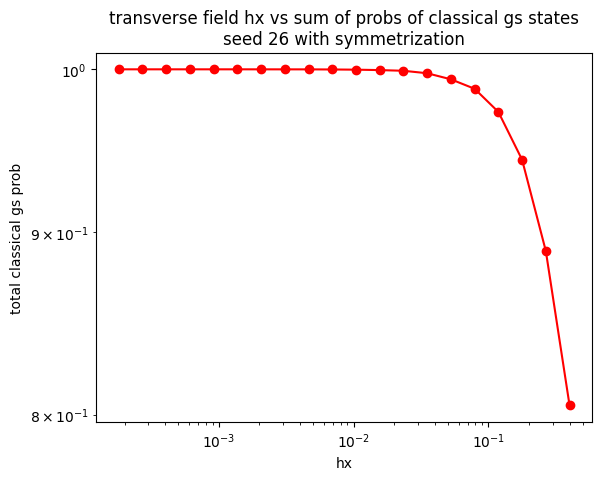

In [197]:
import matplotlib.pyplot as plt

plt.plot(hx, classical_gs_prob_list, marker='o', color='red')
plt.title(f"transverse field hx vs sum of probs of classical gs states\nseed {seed} with symmetrization")
plt.xlabel('hx')
plt.ylabel('total classical gs prob')
plt.xscale('log')
plt.yscale('log')


plt.show()

In [13]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla
from scipy import linalg

N = 12


Instance = data_service.get_instance_class(N)

seed = 26
steps = 17

with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.seed == seed).all()
    )


    


    for instance in instances:
        deg = len(instance.ground_states)

        
        sparse_energy_gaps = np.zeros((deg,steps))
        sparse_fids = np.zeros(steps)
        sparse_classical_gs_probs = np.zeros(steps)
        sparse_gs_amps = np.zeros((steps,2,deg))
        full_energy_gaps = np.zeros((deg,steps))
        full_fids = np.zeros(steps)
        full_classical_gs_probs = np.zeros(steps)
        full_gs_amps = np.zeros((steps,2,deg))

        hx = np.zeros(steps)
        sparse_full_fids = np.zeros(steps)

        try:

            Jij_obj = Jij(np.array(instance.Jij_matrix))

            SG = SKSpinGlass(Jij_obj)

            h = 0.4  * 1.5
            sparse_psi0 = None
            full_psi0  = None

            for i in range(steps):
                h /= 1.5
                H = SG.hamiltonian_at_h(h)

                # SPARSE
                E, v = spla.eigsh(H, k=deg + 1, ncv = 40, which="SA", v0=sparse_psi0)


                sort_order = np.argsort(E)
                E = E[sort_order]
                v = v[:, sort_order]

                old_sparse_psi0 = sparse_psi0
                psi0 = v[:, 0]


                # Symmetrize
                Spsi = np.flip(psi0)
                phiS = (psi0 + Spsi)
                phiS = phiS / np.sqrt(np.dot(phiS,phiS))
                sparse_psi0 = phiS

                for j in range(deg):
                    sparse_energy_gaps[j][i] = E[j+1] - E[j]
                sparse_fids[i] = np.abs(np.vdot(sparse_psi0, old_sparse_psi0)) if old_sparse_psi0 is not None else 0
                sparse_gs_amps[i][0] = v[:, 0][instance.ground_states]
                sparse_gs_amps[i][1] = v[:, 1][instance.ground_states]
                sparse_classical_gs_probs[i] = np.sum(sparse_psi0[instance.ground_states]**2)



                # FULL
                E,v = linalg.eigh(H.todense())
                sort_order = np.argsort(E)
                E = E[sort_order]
                v = v[:, sort_order]

                old_full_psi0 = full_psi0
                psi0 = v[:, 0]



                # Symmetrize
                Spsi = np.flip(psi0)
                phiS = (psi0 + Spsi)
                phiS = phiS / np.sqrt(np.dot(phiS,phiS))
                full_psi0 = phiS

                for j in range(deg):
                    full_energy_gaps[j][i] = E[j+1] - E[j]
                full_fids[i] = np.abs(np.vdot(full_psi0, old_full_psi0)) if old_full_psi0 is not None else 0
                full_gs_amps[i][0] = v[:, 0][instance.ground_states]
                full_gs_amps[i][1] = v[:, 1][instance.ground_states]
                full_classical_gs_probs[i] = np.sum(full_psi0[instance.ground_states]**2)


                
                hx[i] = h
                sparse_full_fids[i] = np.abs(np.vdot(sparse_psi0, full_psi0))
                

                

        except Exception as e:
            print(
                f"Diagonalization fail for seed {instance.seed}, min_e_gap {min_e_gap}, h {h}, fidelity {fidelity}\norgiginal error:\n{e}"
            )

    session.close()

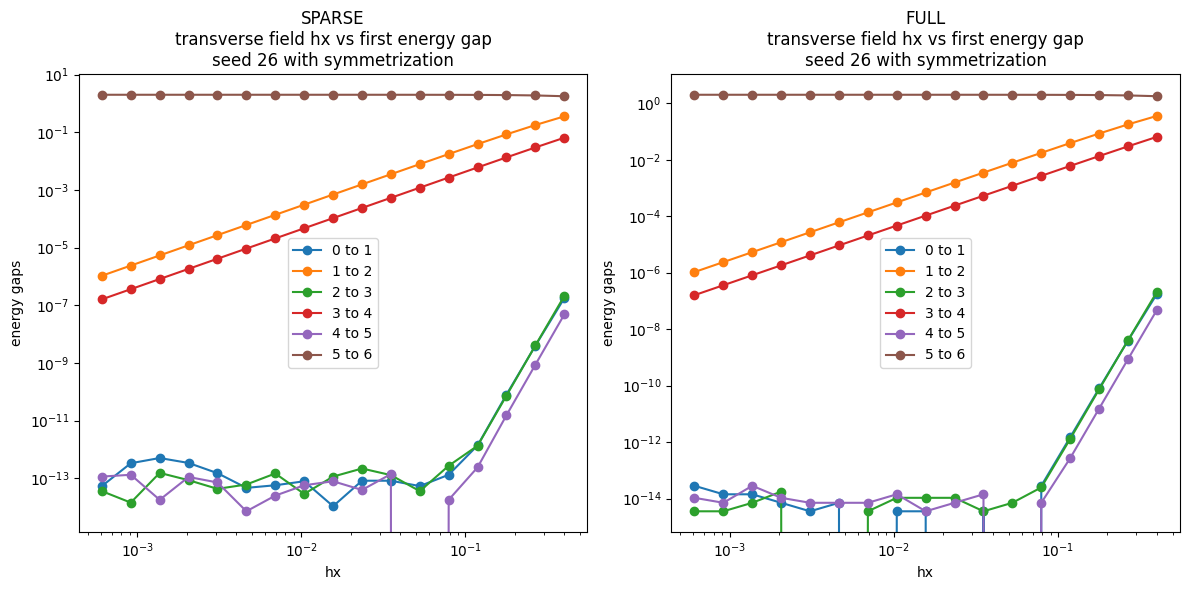

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE\ntransverse field hx vs first energy gap\nseed {seed} with symmetrization")
ax1.set_xlabel('hx')
ax1.set_ylabel('energy gaps')
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.set_title(f"FULL\ntransverse field hx vs first energy gap\nseed {seed} with symmetrization")
ax2.set_xlabel('hx')
ax2.set_ylabel('energy gaps')
ax2.set_yscale('log')
ax2.set_xscale('log')

for i in range(deg):
    ax1.plot(hx,sparse_energy_gaps[i] , marker='o', label=f"{i} to {i+1}")
    ax2.plot(hx,full_energy_gaps[i] , marker='o', label=f"{i} to {i+1}")

ax1.legend()
ax2.legend()

plt.tight_layout()



plt.show()

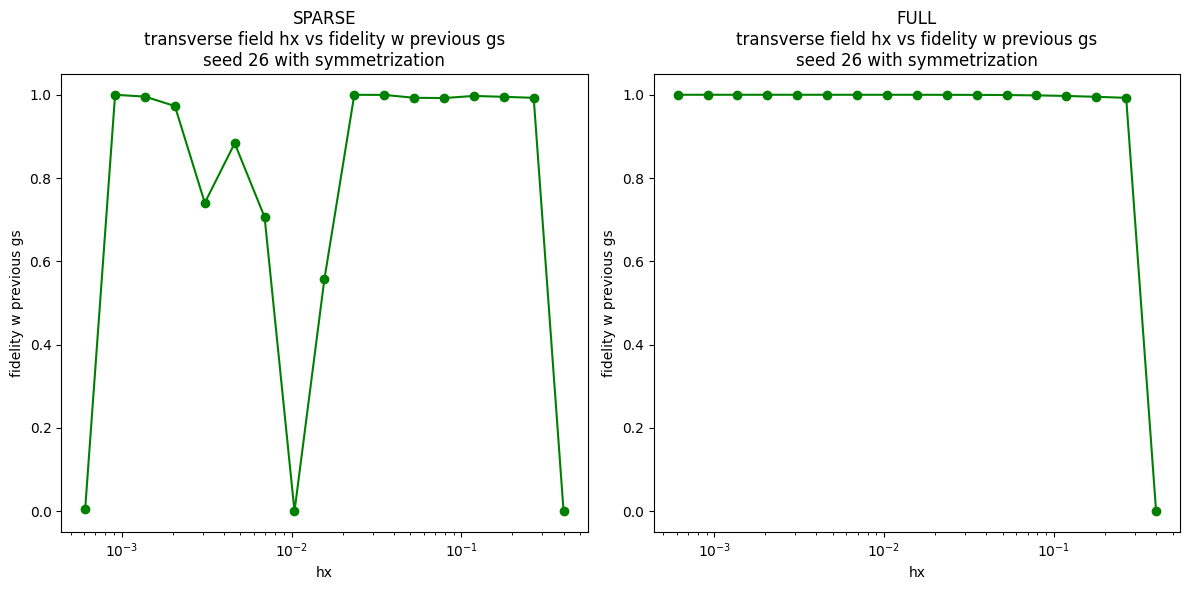

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE\ntransverse field hx vs fidelity w previous gs\nseed {seed} with symmetrization")
ax1.set_xlabel('hx')
ax1.set_ylabel('fidelity w previous gs')
ax1.set_xscale('log')


ax2.set_title(f"FULL\ntransverse field hx vs fidelity w previous gs\nseed {seed} with symmetrization")
ax2.set_xlabel('hx')
ax2.set_ylabel('fidelity w previous gs')
ax2.set_xscale('log')


ax1.plot(hx,sparse_fids , marker='o', color='green')
ax2.plot(hx,full_fids , marker='o', color='green')


plt.tight_layout()


plt.show()

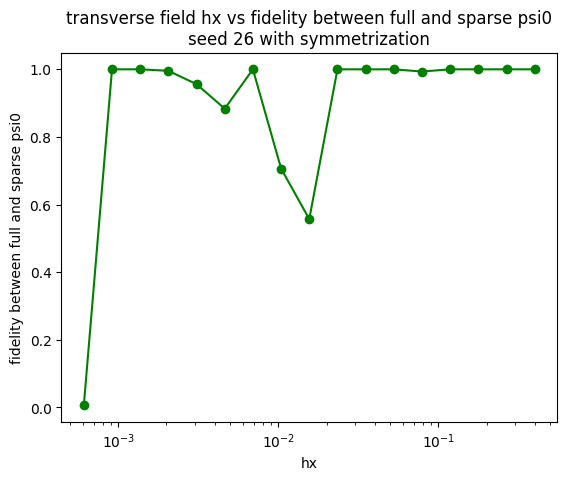

In [16]:
plt.plot(hx, sparse_full_fids, marker='o',color='green')
plt.title(f"transverse field hx vs fidelity between full and sparse psi0\nseed {seed} with symmetrization")
plt.xlabel('hx')
plt.ylabel('fidelity between full and sparse psi0')
plt.xscale('log')


plt.show()

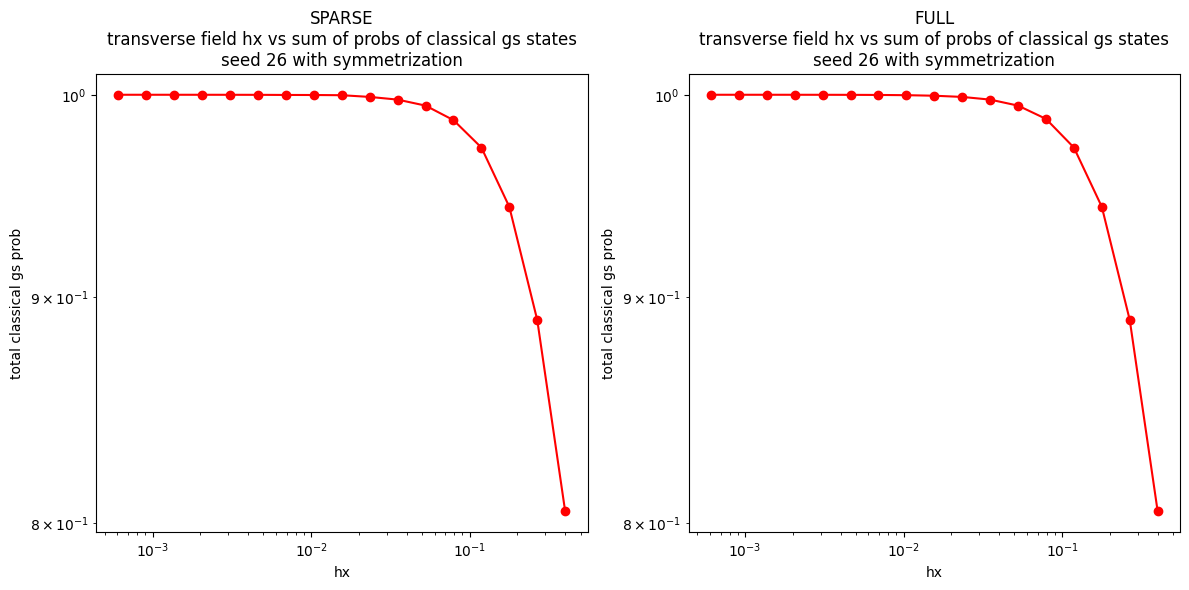

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE\ntransverse field hx vs sum of probs of classical gs states\nseed {seed} with symmetrization")
ax1.set_xlabel('hx')
ax1.set_ylabel('total classical gs prob')
ax1.set_xscale('log')
ax1.set_yscale('log')


ax2.set_title(f"FULL\ntransverse field hx vs sum of probs of classical gs states\nseed {seed} with symmetrization")
ax2.set_xlabel('hx')
ax2.set_ylabel('total classical gs prob')
ax2.set_xscale('log')
ax2.set_yscale('log')


ax1.plot(hx,sparse_classical_gs_probs , marker='o', color='red')
ax2.plot(hx,full_classical_gs_probs , marker='o', color='red')


plt.tight_layout()


plt.show()

In [27]:
sparse_gs_amps[:3]

array([[[-0.32962967, -0.33552541, -0.4257272 , -0.42572721,
         -0.33552542, -0.32962968],
        [-0.32962971, -0.33552545, -0.42572725,  0.42572724,
          0.33552544,  0.3296297 ]],

       [[ 0.34703881,  0.3528631 ,  0.4468891 ,  0.4468891 ,
          0.3528631 ,  0.34703881],
        [ 0.34703881,  0.3528631 ,  0.4468891 , -0.4468891 ,
         -0.3528631 , -0.34703881]],

       [[-0.35772462, -0.36351435, -0.45992903, -0.45992903,
         -0.36351435, -0.35772462],
        [ 0.35772462,  0.36351435,  0.45992903, -0.45992903,
         -0.36351435, -0.35772462]]])

In [39]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla
from scipy import linalg

N = 8


Instance = data_service.get_instance_class(N)

seed = 9

with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.seed == seed).all()
    )

    for instance in instances:
        Jij_obj = Jij(np.array(instance.Jij_matrix))
        SG = SKSpinGlass(Jij_obj)
        h = 0.1
        H = SG.hamiltonian_at_h(h)
        E,v = linalg.eigh(H.todense())
        sort_order = np.argsort(E)
        E = E[sort_order]
        v = v[:, sort_order]

        psi0 = v[:, 0]


In [151]:
# b = [str(row) for row in H.todense().tolist()]
# print('\n'.join(b))
# print(psi0.tolist())
# psi0 / np.array(H@psi0)
N=2
spin_inversion_sym_op = np.zeros((2**N, 2**N))

for i in range(2**N):
    # spin_inversion_sym_op[i][i] = 1 if i<(2**N)//2 else -1
    spin_inversion_sym_op[i][-i-1] = 1


U = np.zeros((2**N, 2**N))

for i in range(2**N):
    U[i][i] = 1 if i<(2**N)//2 else -1
    U[i][-i-1] = 1

U /= np.sqrt(2)




# spin_inversion_sym_op = spin_inversion_sym_op / np.sqrt(2)
# E,v = linalg.eigh(spin_inversion_sym_op)
# sort_order = np.argsort(E)
# E = E[sort_order]
# U = v[:, sort_order].T


# print(E)
# print(v)





# E,v = linalg.eigh(swap_symmetry_op)
# sort_order = np.argsort(E)
# E = E[sort_order]
# v = v[:, sort_order]


# new_H = np.dot(swap_symmetry_op, np.dot( H.todense(), swap_symmetry_op))

# print(new_H)

# E,v = linalg.eigh(new_H)
# sort_order = np.argsort(E)
# E = E[sort_order]
# v = v[:, sort_order]


# psi0 = v[:, 0]
# print([[val for val in v[:, -j].tolist() if val != 0] for j in range(5)])

# print(E[0:5])
# print(psi0)
# print(sum(psi0**2))
# [i for i,val in enumerate(psi0.tolist()) if val != 0]

# print(np.array([1] + [0 for i in range((2**N) - 1) ]))
# print(np.dot(spin_inversion_sym_op, np.array([1] + [0 for i in range((2**N) - 1) ])))

# b = [str(row) for row in U.T.tolist()]
# print('\n'.join(b))


print(U)
# print(U.T)

# print(np.dot(U,U.T))

USU = np.dot(U,np.dot(spin_inversion_sym_op, U.T))


# print(U)
# print(U.T)
# print(spin_inversion_sym_op)

b = [str(row) for row in USU.tolist()]
print('\n'.join(b))



[[ 0.70710678  0.          0.          0.70710678]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.          0.         -0.70710678]]
[0.9999999999999998, 0.0, 0.0, 2.2371143170757382e-17]
[0.0, 0.9999999999999998, 2.2371143170757382e-17, 0.0]
[0.0, -2.2371143170757382e-17, -0.9999999999999998, 0.0]
[-2.2371143170757382e-17, 0.0, 0.0, -0.9999999999999998]


In [153]:
N = 3
U = np.zeros((2**N, 2**N))

for i in range(2**N):
    U[i][i] = 1 if i<(2**N)//2 else -1
    U[i][-i-1] = 1

U /= np.sqrt(2)



Jij_obj = Jij(np.array([[1,1,1],[1,1,1]]))
SG = SKSpinGlass(Jij_obj)
h = 0.1
H = SG.hamiltonian_at_h(h)
print(H.todense())


UHU = np.dot(U,np.dot(H.todense(), U.T))
b = [str(row) for row in UHU.tolist()]
print('\n'.join(b))






E,v = linalg.eigh(UHU[0:4, 0:4])
sort_order = np.argsort(E)
E = E[sort_order]
v = v[:, sort_order]

print(E)
print(v)
print(v[:, 0])

E,v = linalg.eigh(UHU[4:8, 4:8])
sort_order = np.argsort(E)
E = E[sort_order]
v = v[:, sort_order]

print(E)
print(v)
print(v[:, 0])


[[-3.  -0.1 -0.1  0.  -0.1  0.   0.   0. ]
 [-0.1  1.   0.  -0.1  0.  -0.1  0.   0. ]
 [-0.1  0.   1.  -0.1  0.   0.  -0.1  0. ]
 [ 0.  -0.1 -0.1  1.   0.   0.   0.  -0.1]
 [-0.1  0.   0.   0.   1.  -0.1 -0.1  0. ]
 [ 0.  -0.1  0.   0.  -0.1  1.   0.  -0.1]
 [ 0.   0.  -0.1  0.  -0.1  0.   1.  -0.1]
 [ 0.   0.   0.  -0.1  0.  -0.1 -0.1 -3. ]]
[-2.9999999999999996, -0.09999999999999999, -0.09999999999999999, -0.09999999999999999, 7.765484401220529e-19, -7.765484401220529e-19, -7.765484401220529e-19, -4.390887295024351e-17]
[-0.09999999999999999, 0.9999999999999998, -0.09999999999999999, -0.09999999999999999, -7.765484401220529e-19, 7.765484401220529e-19, -2.2371143170757382e-17, -7.765484401220529e-19]
[-0.09999999999999999, -0.09999999999999999, 0.9999999999999998, -0.09999999999999999, -7.765484401220529e-19, -2.2371143170757382e-17, 7.765484401220529e-19, -7.765484401220529e-19]
[-0.09999999999999999, -0.09999999999999999, -0.09999999999999999, 0.9999999999999998, -2.2371143170757382

In [212]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla
from scipy import linalg

N = 12


Instance = data_service.get_instance_class(N)

seed = 26

with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.seed == seed).all()
    )

    for instance in instances:
        U = np.zeros((2**N, 2**N))

        for i in range(2**N):
            U[i][i] = 1 if i<(2**N)//2 else -1
            U[i][-i-1] = 1

        U /= np.sqrt(2)

        
        Jij_obj = Jij(np.array(instance.Jij_matrix))
        SG = SKSpinGlass(Jij_obj)
        h = 1e-5
        H = SG.hamiltonian_at_h(h)

        E,v = linalg.eigh(H.todense())
        sort_order = np.argsort(E)
        Eh = E[sort_order]
        vh = v[:, sort_order]

        UHU = np.dot(U,np.dot(H.todense(), U.T))
        b = [str([round(n,2) for n in row]) for row in UHU.tolist()]
        # print('\n'.join(b))

        M = 2**N

        UHU1q = UHU[0:M//2, 0:M//2]

        print(np.sum(UHU1q * UHU1q))

        UHU3q = UHU[M//2 : M, 0:M//2]

        print(np.sum(UHU3q * UHU3q))


        UHU2q = UHU[0:M//2 , M//2 : M]

        print(np.sum(UHU2q * UHU2q))


        UHU4q = UHU[M//2 : M , M//2 : M]

        print(np.sum(UHU4q * UHU4q))
        

        E,v = linalg.eigh(UHU1q)
        sort_order = np.argsort(E)
        E = E[sort_order]
        v1 = v[:, sort_order]

        E1q = E[:5]

        E,v = linalg.eigh(UHU4q)
        sort_order = np.argsort(E)
        E = E[sort_order]
        v2 = v[:, sort_order]

        E4q = E[:5]


        print(E1q)
        print(E4q)
        print(E1q-E4q)

        print(E1q[1] - E1q[0])
        print(E4q[1] - E4q[0])

        

135168.00002949114
0.0
0.0
135168.0000204798
[-24. -24. -24. -22. -22.]
[-24. -24. -24. -22. -22.]
[ 7.10542736e-15  2.48689958e-14 -7.10542736e-15  1.06581410e-14
  7.10542736e-15]
2.843307811417617e-10
2.843130175733677e-10


In [215]:
# Block diagonal
psi0b = np.dot(U,np.array(list(v1[:,0]) + [0 for i in range(M//2)]))

# [120, 135]
print(psi0b[[212, 340, 470, 3625, 3755, 3883]])


# Ordinary
psi0h  = vh[:,0]
print(psi0h[[212, 340, 470, 3625, 3755, 3883]])


print(psi0b[[212, 340, 470, 3625, 3755, 3883]] / psi0h[[212, 340, 470, 3625, 3755, 3883]])

print(np.dot(psi0b,psi0h))

# print(np.dot(v1[:,0],v2[:,0]))


[0.36860898 0.37436408 0.47326415 0.47326415 0.37436408 0.36860898]
[-8.92039718e-14 -9.05902064e-14 -1.14445498e-13  6.69306736e-01
  5.29424454e-01  5.21285181e-01]
[-4.13220370e+12 -4.13250052e+12 -4.13527975e+12  7.07096053e-01
  7.07115194e-01  7.07115790e-01]
0.7071067811203497


In [ ]:
# Energy gap between sym and anti sym
# Compute first (d/2) + 1 eigenenergies


In [49]:
import numpy as np

from database.models import InstancesN8, InstancesN12
from tfim_sk_infd.models.Jij import Jij
from tfim_sk_infd.models.SKSpinGlass import SKSpinGlass
import data_service
from scipy.sparse import linalg as spla
from scipy import linalg

N = 12
M = 2**N


Instance = data_service.get_instance_class(N)

seed = 26
steps = 17

with data_service.get_session() as session:

    instances: list[InstancesN8 | InstancesN12] = (
        session.query(Instance).where(Instance.seed == seed).all()
    )

    for instance in instances:

        deg = len(instance.ground_states)

        sparse_energy_spectra_1q = np.zeros((deg//2,steps))
        sparse_energy_spectra_4q = np.zeros((deg//2,steps))
        sparse_q_energy_diffs = np.zeros(steps)
        sparse_fidelities_1q = np.zeros(steps)
        sparse_fidelities_4q = np.zeros(steps)
        sparse_classical_gs_probs_1q = np.zeros(steps)
        sparse_classical_gs_probs_4q = np.zeros(steps)


        full_energy_spectra_1q = np.zeros((deg//2,steps))
        full_energy_spectra_4q = np.zeros((deg//2,steps))
        full_q_energy_diffs = np.zeros(steps)
        full_fidelities_1q = np.zeros(steps)
        full_fidelities_4q = np.zeros(steps)
        full_classical_gs_probs_1q = np.zeros(steps)
        full_classical_gs_probs_4q = np.zeros(steps)


        hx = np.zeros(steps)
        sparse_vs_full_fids_1q = np.zeros(steps)
        sparse_vs_full_fids_4q = np.zeros(steps)



        # Initialize spin glass and spin inversion operator U
        Jij_obj = Jij(np.array(instance.Jij_matrix))
        SG = SKSpinGlass(Jij_obj)
        U = np.zeros((M, M))
        for i in range(M):
            U[i][i] = 1 if i<(M)//2 else -1
            U[i][-i-1] = 1
        U /= np.sqrt(2)

        h = 0.4  * 1.5
        sparse_psi0_1q = None
        sparse_psi0_4q = None
        full_psi0_1q  = None
        full_psi0_4q  = None

        for i in range(steps):

            # Calculate hamiltonian
            h /= 1.5
            H = SG.hamiltonian_at_h(h)
            UHU = np.dot(U,np.dot(H.todense(), U.T))
            UHU1q = UHU[0:M//2, 0:M//2]
            UHU4q = UHU[M//2 : M , M//2 : M]



            ## SPARSE

            # Diagonalize quadrants
            E1q, v1q = spla.eigsh(UHU1q, k=(deg//2) + 1, which="SA", v0=sparse_psi0_1q)
            sort_order = np.argsort(E1q)
            E1q = E1q[sort_order]
            v1q = v1q[:, sort_order]
            old_sparse_psi0_1q = sparse_psi0_1q
            sparse_psi0_1q = v1q[:, 0]
            sparse_psi0_1q_complete = np.dot(U,np.array(list(sparse_psi0_1q) + [0 for _ in range(M//2)]))

            E4q, v4q = spla.eigsh(UHU4q, k=(deg//2) + 1, which="SA", v0=sparse_psi0_4q)
            sort_order = np.argsort(E4q)
            E4q = E4q[sort_order]
            v4q = v4q[:, sort_order]
            old_sparse_psi0_4q = sparse_psi0_4q
            sparse_psi0_4q = v4q[:, 0]
            sparse_psi0_4q_complete = np.dot(U,np.array([0 for _ in range(M//2)] + list(sparse_psi0_4q)))
            
            # Fill in data arrays
            for j in range(deg//2):
                sparse_energy_spectra_1q[j][i] = E1q[j+1] - E1q[j]
                sparse_energy_spectra_4q[j][i] = E4q[j+1] - E4q[j]
            sparse_q_energy_diffs[i] = E4q[0] - E1q[0]
            sparse_fidelities_1q[i] = np.abs(np.vdot(sparse_psi0_1q, old_sparse_psi0_1q)) if old_sparse_psi0_1q is not None else 1
            sparse_fidelities_4q[i] = np.abs(np.vdot(sparse_psi0_4q, old_sparse_psi0_4q)) if old_sparse_psi0_4q is not None else 1
            sparse_classical_gs_probs_1q[i] = np.sum(sparse_psi0_1q_complete[instance.ground_states]**2)
            sparse_classical_gs_probs_4q[i] = np.sum(sparse_psi0_4q_complete[instance.ground_states]**2)


            
            ## FULL

            # Diagonalize quadrants
            E1q, v1q = linalg.eigh(UHU1q)
            sort_order = np.argsort(E1q)
            E1q = E1q[sort_order]
            v1q = v1q[:, sort_order]
            old_full_psi0_1q = full_psi0_1q
            full_psi0_1q = v1q[:, 0]
            full_psi0_1q_complete = np.dot(U,np.array(list(full_psi0_1q) + [0 for _ in range(M//2)]))

            E4q, v4q = linalg.eigh(UHU4q)
            sort_order = np.argsort(E4q)
            E4q = E4q[sort_order]
            v4q = v4q[:, sort_order]
            old_full_psi0_4q = full_psi0_4q
            full_psi0_4q = v4q[:, 0]
            full_psi0_4q_complete = np.dot(U,np.array([0 for _ in range(M//2)] + list(full_psi0_4q)))
            
            # Fill in data arrays
            for j in range(deg//2):
                full_energy_spectra_1q[j][i] = E1q[j+1] - E1q[j]
                full_energy_spectra_4q[j][i] = E4q[j+1] - E4q[j]
            full_q_energy_diffs[i] = E4q[0] - E1q[0]
            full_fidelities_1q[i] = np.abs(np.vdot(full_psi0_1q, old_full_psi0_1q)) if old_full_psi0_1q is not None else 1
            full_fidelities_4q[i] = np.abs(np.vdot(full_psi0_4q, old_full_psi0_4q)) if old_full_psi0_4q is not None else 1
            full_classical_gs_probs_1q[i] = np.sum(full_psi0_1q_complete[instance.ground_states]**2)
            full_classical_gs_probs_4q[i] = np.sum(full_psi0_4q_complete[instance.ground_states]**2)

            
            hx[i] = h
            sparse_vs_full_fids_1q[i] = np.abs(np.vdot(sparse_psi0_1q, full_psi0_1q))
            sparse_vs_full_fids_4q[i] = np.abs(np.vdot(sparse_psi0_4q, full_psi0_4q))
                

                



    session.close()

ArpackNoConvergence: ARPACK error -1: No convergence (20481 iterations, 3/4 eigenvectors converged)

In [51]:
len(hx)

17

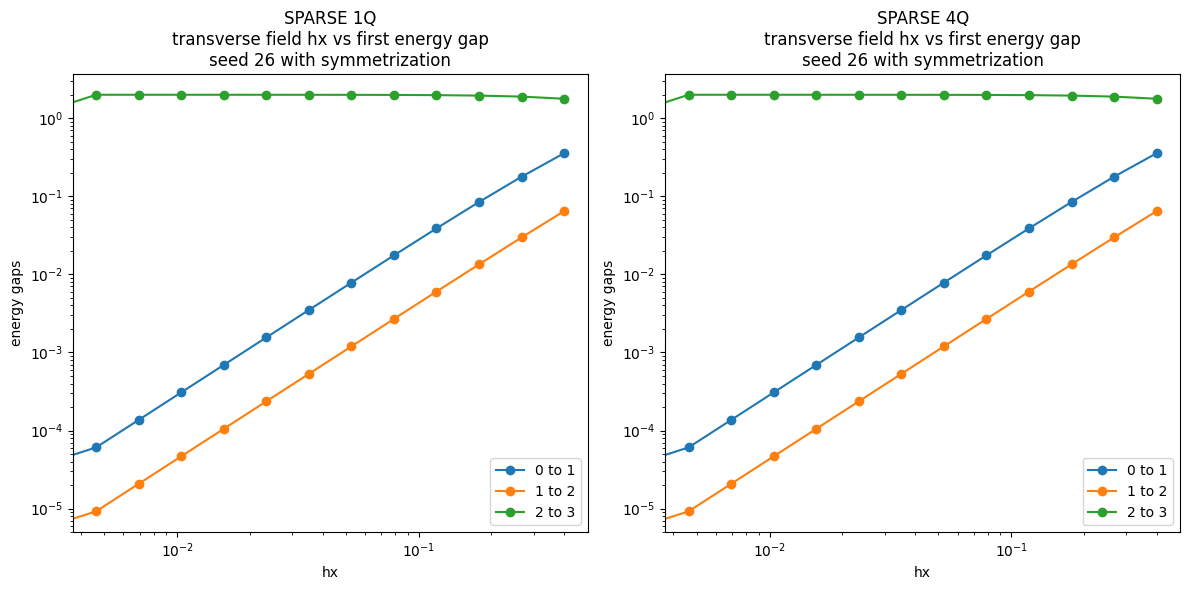

In [52]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE 1Q\ntransverse field hx vs first energy gap\nseed {seed} with symmetrization")
ax1.set_xlabel('hx')
ax1.set_ylabel('energy gaps')
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.set_title(f"SPARSE 4Q\ntransverse field hx vs first energy gap\nseed {seed} with symmetrization")
ax2.set_xlabel('hx')
ax2.set_ylabel('energy gaps')
ax2.set_yscale('log')
ax2.set_xscale('log')

for i in range(deg//2):
    ax1.plot(hx,sparse_energy_spectra_1q[i] , marker='o', label=f"{i} to {i+1}")
    ax2.plot(hx,sparse_energy_spectra_4q[i] , marker='o', label=f"{i} to {i+1}")

ax1.legend()
ax2.legend()

plt.tight_layout()



plt.show()

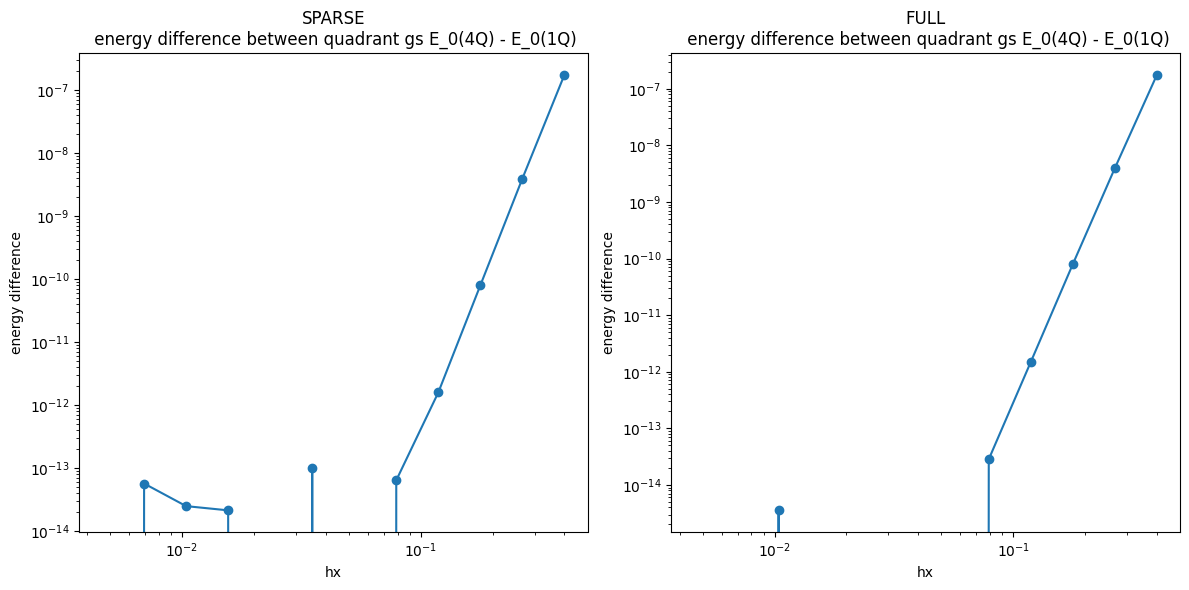

In [53]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE\n energy difference between quadrant gs E_0(4Q) - E_0(1Q)")
ax1.set_xlabel('hx')
ax1.set_ylabel('energy difference')
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.set_title(f"FULL\n energy difference between quadrant gs E_0(4Q) - E_0(1Q)")
ax2.set_xlabel('hx')
ax2.set_ylabel('energy difference')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.plot(hx, sparse_q_energy_diffs, marker='o')
ax2.plot(hx, full_q_energy_diffs, marker='o')

plt.tight_layout()



plt.show()

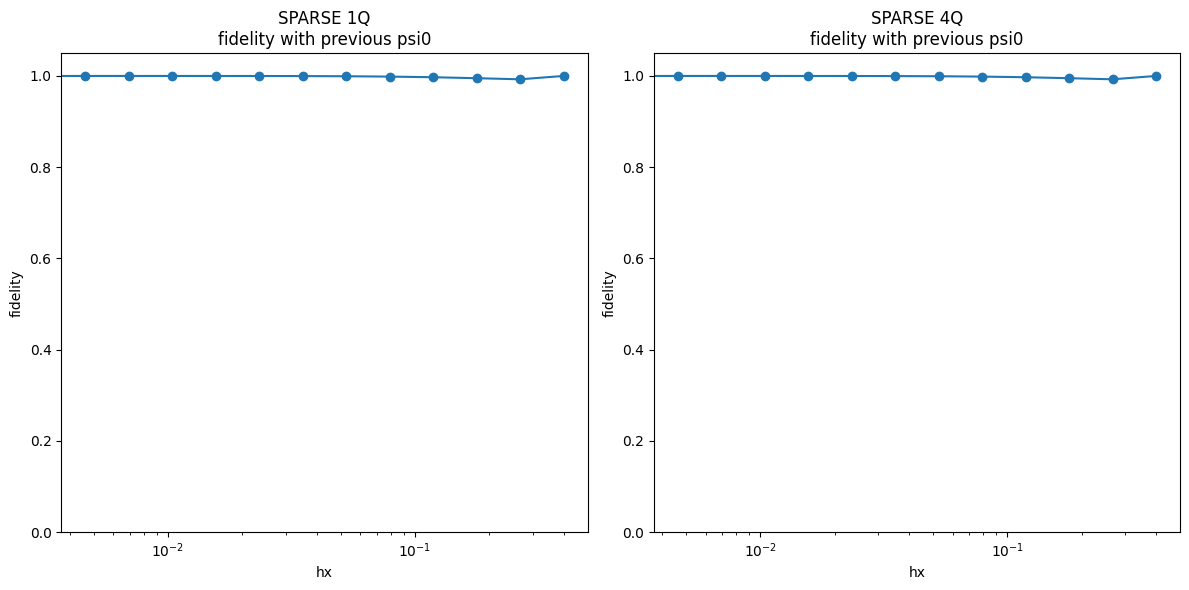

In [54]:


import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE 1Q\nfidelity with previous psi0")
ax1.set_xlabel('hx')
ax1.set_ylabel('fidelity')
ax1.set_xscale('log')
ax1.set_ylim(0,1.05)



ax2.set_title(f"SPARSE 4Q\nfidelity with previous psi0")
ax2.set_xlabel('hx')
ax2.set_ylabel('fidelity')
ax2.set_xscale('log')
ax2.set_ylim(0,1.05)


ax1.plot(hx,sparse_fidelities_1q, marker='o')
ax2.plot(hx,sparse_fidelities_4q, marker='o')


plt.tight_layout()



plt.show()


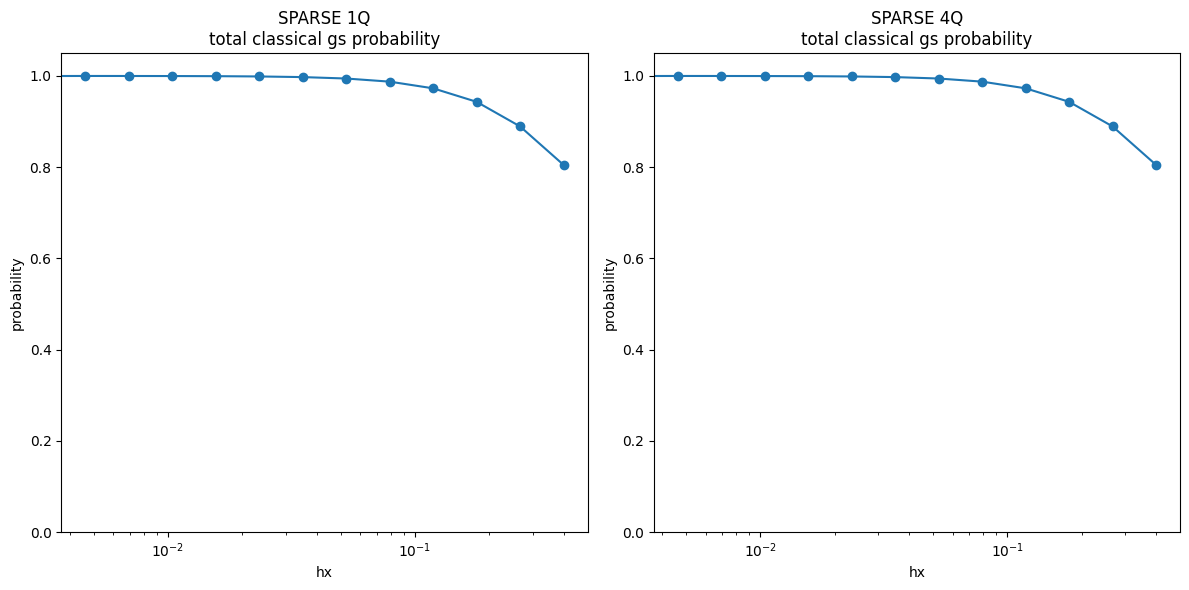

In [55]:




import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"SPARSE 1Q\ntotal classical gs probability")
ax1.set_xlabel('hx')
ax1.set_ylabel('probability')
ax1.set_xscale('log')
ax1.set_ylim(0,1.05)



ax2.set_title(f"SPARSE 4Q\ntotal classical gs probability")
ax2.set_xlabel('hx')
ax2.set_ylabel('probability')
ax2.set_xscale('log')
ax2.set_ylim(0,1.05)


ax1.plot(hx,sparse_classical_gs_probs_1q, marker='o')
ax2.plot(hx,sparse_classical_gs_probs_4q, marker='o')


plt.tight_layout()



plt.show()


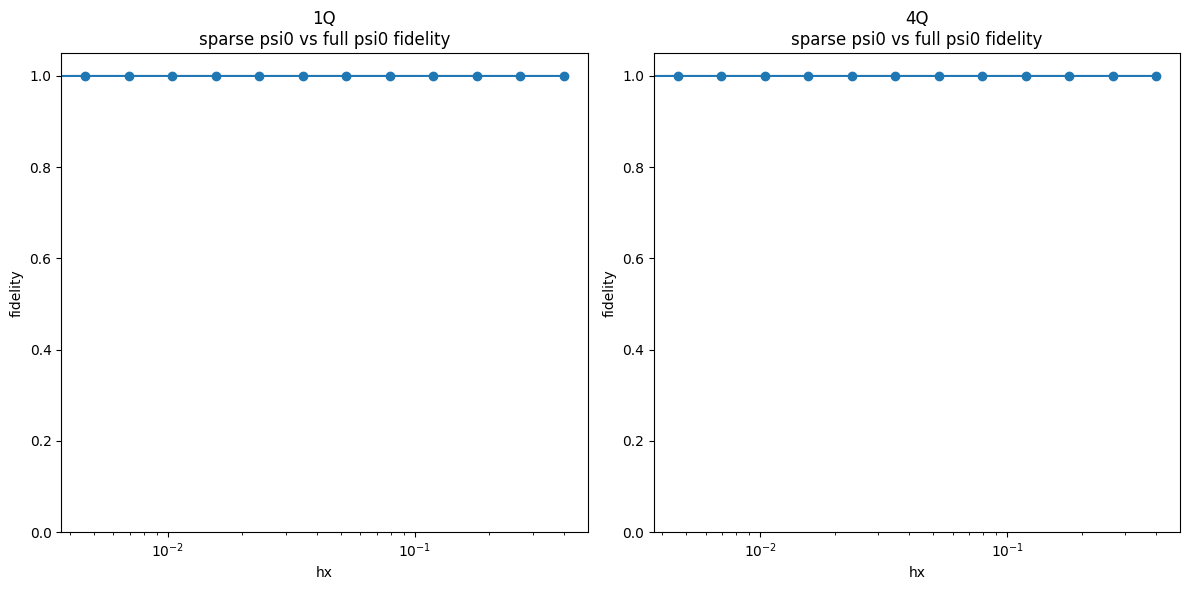

In [56]:






import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(f"1Q\nsparse psi0 vs full psi0 fidelity")
ax1.set_xlabel('hx')
ax1.set_ylabel('fidelity')
ax1.set_xscale('log')
ax1.set_ylim(0,1.05)



ax2.set_title(f"4Q\nsparse psi0 vs full psi0 fidelity")
ax2.set_xlabel('hx')
ax2.set_ylabel('fidelity')
ax2.set_xscale('log')
ax2.set_ylim(0,1.05)


ax1.plot(hx,sparse_vs_full_fids_1q, marker='o')
ax2.plot(hx,sparse_vs_full_fids_4q, marker='o')


plt.tight_layout()



plt.show()


In [37]:
print(full_psi0_1q_complete[instance.ground_states]**2)
print(full_psi0_4q_complete[instance.ground_states]**2)

[0.10296564 0.05850457 0.16920801 0.05850457 0.10296564 0.10296564
 0.05850457 0.16920801 0.05850457 0.10296564]
[0.10304544 0.05829214 0.16948438 0.05829214 0.10304544 0.10304544
 0.05829214 0.16948438 0.05829214 0.10304544]


In [57]:
( 0.4  * 1.5)/(1.5 ** 17)

0.000608975536138978

In [72]:
import time
N = 16
M = 2**N
psi0_1q = np.zeros(M//2)

s = time.time()
test = np.append(psi0_1q, np.zeros(M//2))
print(time.time()-s)
s = time.time()
np.array(list(psi0_1q) + [0 for _ in range(SG.M//2)])
print(time.time()-s)

0.0006580352783203125
0.002481222152709961


In [68]:
test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [83]:
[0.1* (0.5 ** i) for i in range(10)]

[0.1,
 0.05,
 0.025,
 0.0125,
 0.00625,
 0.003125,
 0.0015625,
 0.00078125,
 0.000390625,
 0.0001953125]